# Plotting Vertical Sections

In this section, we create a vertical section using the bathymetry and distances previously computed.

In [27]:
#Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import netCDF4
from shapely.geometry import Point, LineString, MultiPoint
from scipy.interpolate import griddata
import scipy.interpolate
import cmocean

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/')
#Import custom functions
from read_CTD import read_CTD    #To read CTD files
from out_outliers import out_outliers     #To replace outliers
import plotting_functions as plot   #To plot vertical profiles, T-S and vertical sections
from maps import mapa, map_layers    #To plot maps
from stations import stations
from out_outliers import out_outliers     #To replace outliers
from dict_units import dict_units     #to store the units of the variables

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/distance')
from distances import *

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/transsects_functions/')
from bathymetry_transsects import bathymetry_transsects
from transsect_distances import transsect_distances
from transsects_dataconc import transsects_dataconc

from matplotlib.colors import Normalize
class PiecewiseNorm(Normalize):
    def __init__(self, levels, clip=False):
        # the input levels
        self._levels = np.sort(levels)
        # corresponding normalized values between 0 and 1
        self._normed = np.linspace(0, 1, len(levels))
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return np.ma.masked_array(np.interp(value, self._levels, self._normed))

#To turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
#Data reading and outlier replacement
data_dirs = ['C:/Users/pauab/Universidad/Data/TFM/CTD_recalc/']
data=read_CTD(data_dirs)

for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)
    data[ncast]['pressure']=data[ncast].index
    data[ncast].index = np.arange(0, len(data[ncast].index))
    
#Dict with all transsects
transsects = {'transsect_0':['15','12','13','14'],
              'transsect_1':['19','18','17','16'],
              'transsect_2':['24','23','22','21'],
              'transsect_3':['26','27','28','29'],
              'transsect_4':['31','32','33','34'],
              'transsect_5':['38','37','36','35'],
              'transsect_6':['43','44','45','46']}

variables = list(data['09'].keys())
#Import a dictionary with the units of the variables
units = dict_units(variables)

In [17]:
#Select a transsect
##t = ['transsect_0']
##transsect = transsects[t]

#Compute and store bathymetry of the transsect
##transsects_sel = {}
##transsects_sel[t] = transsect

#path to bathymetry file
gebco = 'C:/Users/pauab/Universidad/Data/TFM/Bathymetry/GEBCO_16_Feb_2022_8d3ca050bc32/gebco_2021_n44.857177734375_s34.991455078125_w-11.97509765625_e-4.37255859375.nc'

#function that computes and stores the bathymetry in a dict
transsects_bath = bathymetry_transsects(data, transsects=transsects, xoffset=False, gebco=gebco)

In [18]:
#Compute the distances between the stations of a transsect
distances = transsect_distances(data, transsects=transsects)

In [19]:
#Store the data of the stations of a transsect in a concatenate DF (useful to then plot)
dataset_transsects = transsects_dataconc(data, transsects = transsects, distances = distances)

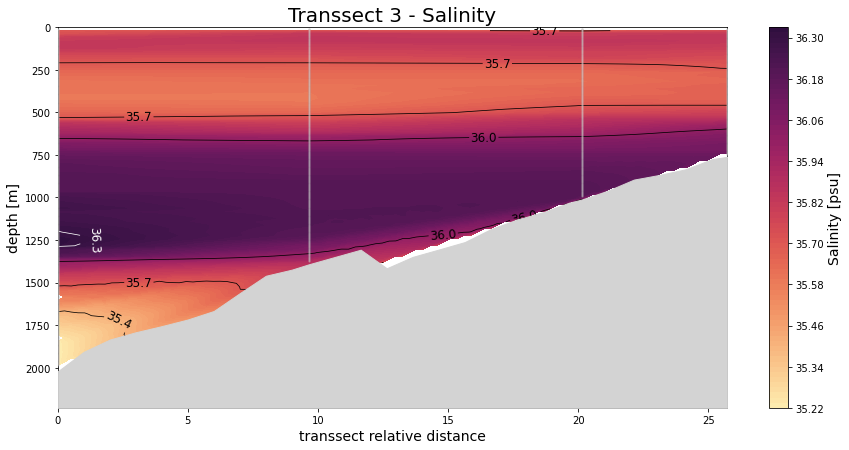

In [28]:
#Select the plotting parameters
t = 'transsect_3'
variable = 'salinity'
#cmap = 'viridis'
cmap = cmocean.cm.matter
interpolation = 'linear'    #other options are 'cubic', 'linear', 'nearest'
fontsize_title = 20
fontsize_label = 14

#Plotting the vertical section
fig, ax = plt.subplots(1,1, figsize = (15,7))

n_dep = dataset_transsects[t]['depth'].max()
maxdist = dataset_transsects[t]['distances'].max()/1000

#Axis limits
ax.set_xlim(0, maxdist)
ax.set_ylim(n_dep+250, 0)
ax.margins(0.05)

#PLot the bathymetry
ax.fill_between(transsects_bath[t]['distance']/1000, transsects_bath[t]['bathymetry']*-1, n_dep+250, 
                 color='lightgray', zorder=100)

#Creating the grid
points = list(zip(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth']))
xi, yi = np.mgrid[0:maxdist:100j, 0:n_dep:100j]
grid_ztest = griddata(points, dataset_transsects[t][variable], (xi, yi), method=interpolation, rescale=True )

##Creating the grid - version 2
##interp = scipy.interpolate.Rbf(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], ompa_transsect[watermass], function=interpolation)
##xi, yi = np.mgrid[0:maxdist:50j, depth_range_upper:n_dep:50j]
##zi = interp(xi, yi)

#Colouring the grid
#levels = []

handle = ax.contourf(xi, yi, grid_ztest, cmap=cmap, levels=100)
#handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
#handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
#handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')

#if we use a divergent color map and want the zero to be the white colour
##if abs(grid_ztest.max()) > abs(grid_ztest.min()):
##    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=grid_ztest.max(), vmin=-grid_ztest.max())
##else:
##    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=-grid_ztest.min(), vmin=grid_ztest.min())

#contouring 
clevels = 3    #int or list
CS = ax.contour(xi, yi, grid_ztest, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)
ax.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=12, zorder=20)

#Ploting the CTD stations cast
b = ax.scatter(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)

#colorbar
#cb = fig.colorbar(handle, ax=ax0, ticks=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
cb = fig.colorbar(handle, ax=ax)
cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
plt.title('Transsect '+t[-1]+' - '+variable[0].upper()+variable[1:], fontsize=fontsize_title)

plt.show()

## Plotting all the transects

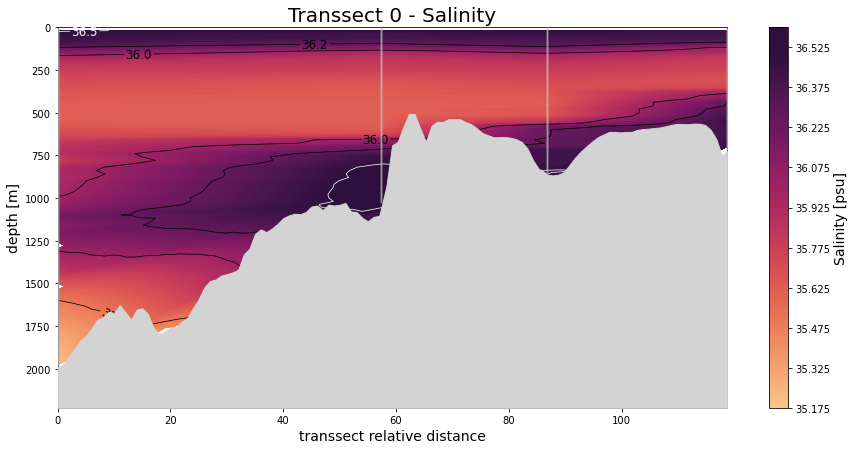

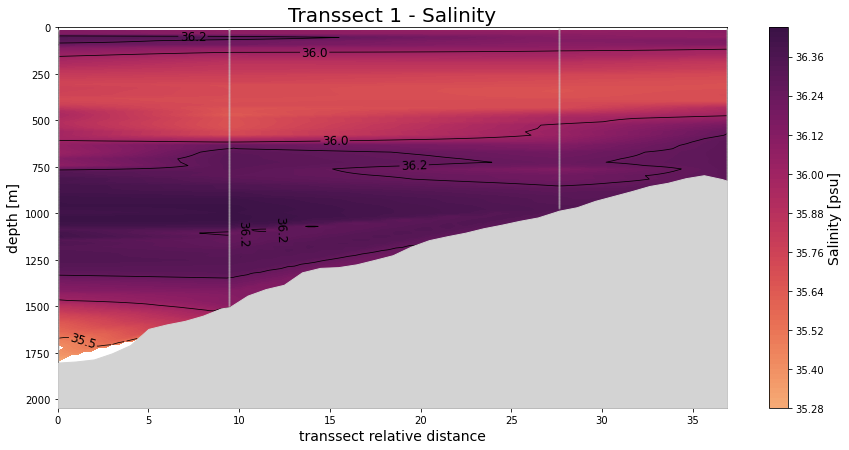

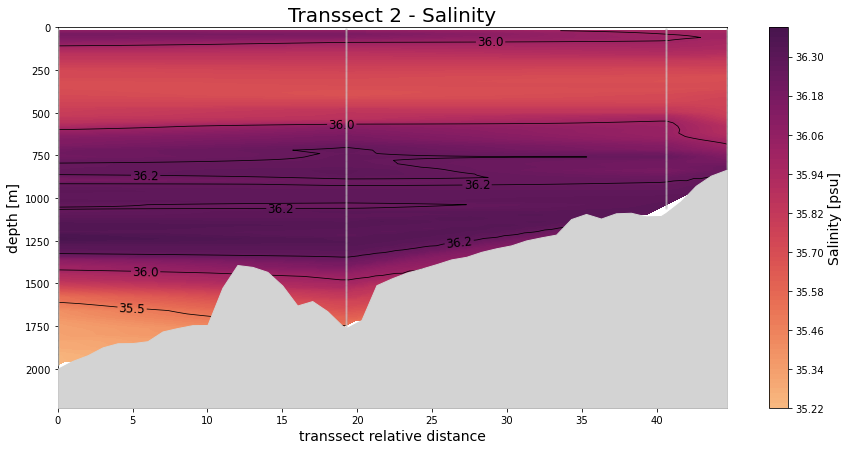

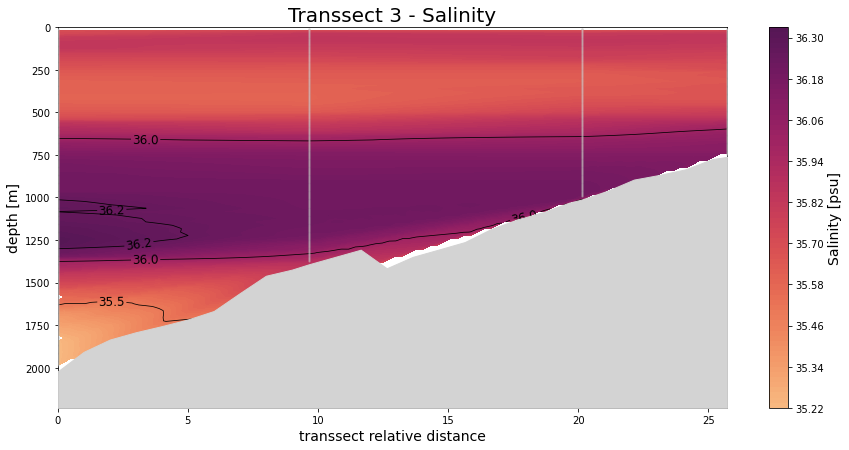

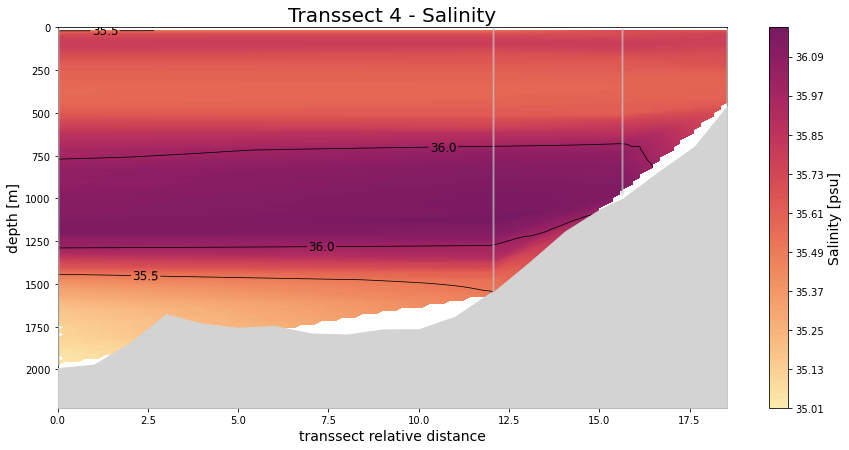

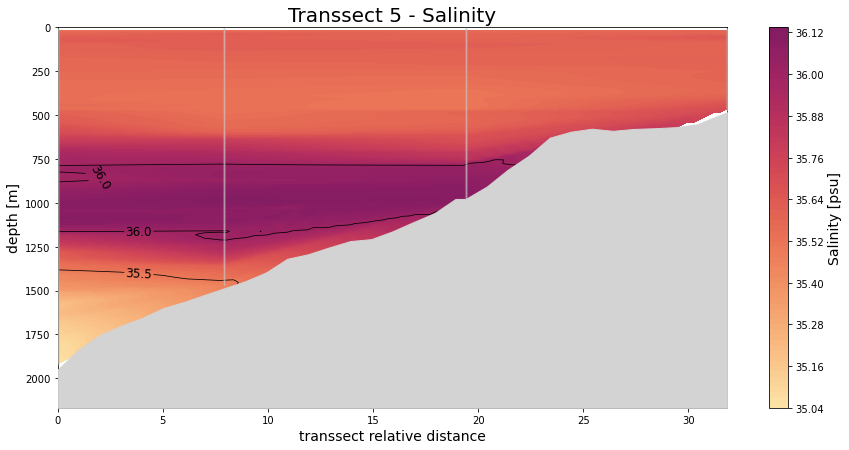

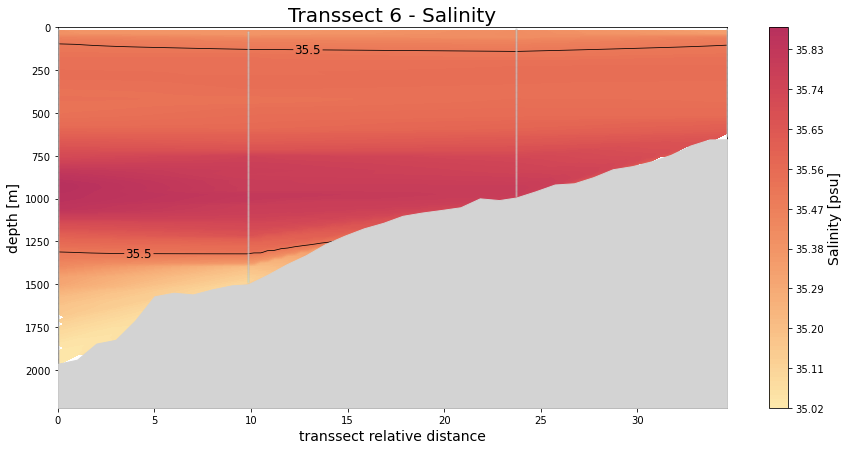

In [29]:
#Select the plotting parameters
#t = 'transsect_3'
variable = 'salinity'
#cmap = 'viridis'
cmap = cmocean.cm.matter
interpolation = 'linear'    #other options are 'cubic', 'linear', 'nearest'
fontsize_title = 20
fontsize_label = 14

levels = np.linspace(35, 36.5, 100)
for t in transsects.keys():
    
    #Plotting the vertical section
    fig, ax = plt.subplots(1,1, figsize = (15,7))
    
    n_dep = dataset_transsects[t]['depth'].max()
    maxdist = dataset_transsects[t]['distances'].max()/1000
    
    #Axis limits
    ax.set_xlim(0, maxdist)
    ax.set_ylim(n_dep+250, 0)
    ax.margins(0.05)
    
    #PLot the bathymetry
    ax.fill_between(transsects_bath[t]['distance']/1000, transsects_bath[t]['bathymetry']*-1, n_dep+250, 
                     color='lightgray', zorder=100)
    
    #Creating the grid
    points = list(zip(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth']))
    xi, yi = np.mgrid[0:maxdist:100j, 0:n_dep:100j]
    grid_ztest = griddata(points, dataset_transsects[t][variable], (xi, yi), method=interpolation, rescale=True )
    
    ##Creating the grid - version 2
    ##interp = scipy.interpolate.Rbf(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], ompa_transsect[watermass], function=interpolation)
    ##xi, yi = np.mgrid[0:maxdist:50j, depth_range_upper:n_dep:50j]
    ##zi = interp(xi, yi)
    
    #Colouring the grid
    #levels = []
    
    #handle = ax.contourf(xi, yi, grid_ztest, cmap=cmap, levels=100)
    handle = ax.contourf(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
    #handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
    #handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
    
    #if we use a divergent color map and want the zero to be the white colour
    ##if abs(grid_ztest.max()) > abs(grid_ztest.min()):
    ##    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=grid_ztest.max(), vmin=-grid_ztest.max())
    ##else:
    ##    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=-grid_ztest.min(), vmin=grid_ztest.min())
    
    #contouring 
    clevels = [35, 35.5, 36, 36.25, 36.5]   #int or list
    CS = ax.contour(xi, yi, grid_ztest, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)
    ax.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=12, zorder=20)
    
    #Ploting the CTD stations cast
    b = ax.scatter(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)
    
    #colorbar
    #cb = fig.colorbar(handle, ax=ax0, ticks=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
    cb = fig.colorbar(handle, ax=ax)
    cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)
    
    #titles
    plt.ylabel('depth [m]', fontsize=fontsize_label)
    plt.xlabel('transsect relative distance', fontsize=fontsize_label)
    plt.title('Transsect '+t[-1]+' - '+variable[0].upper()+variable[1:], fontsize=fontsize_title)
    
    plt.show()

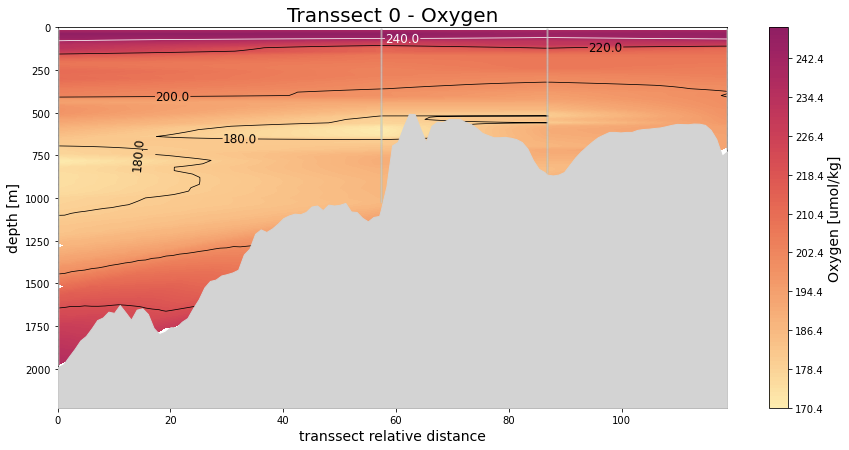

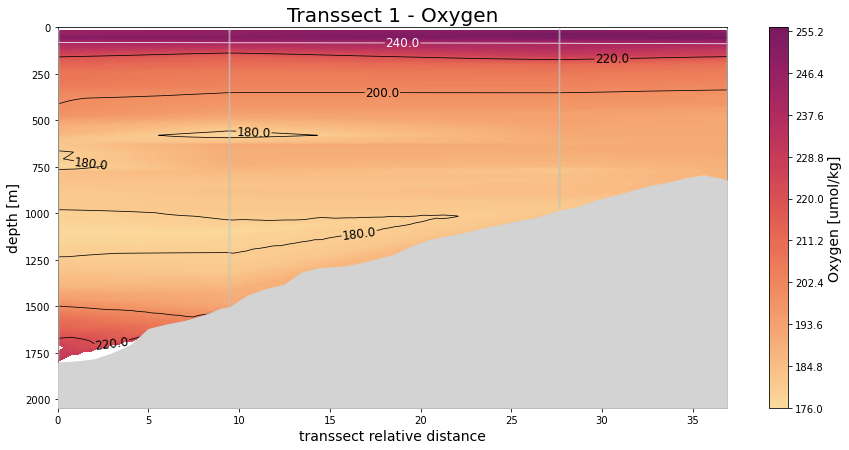

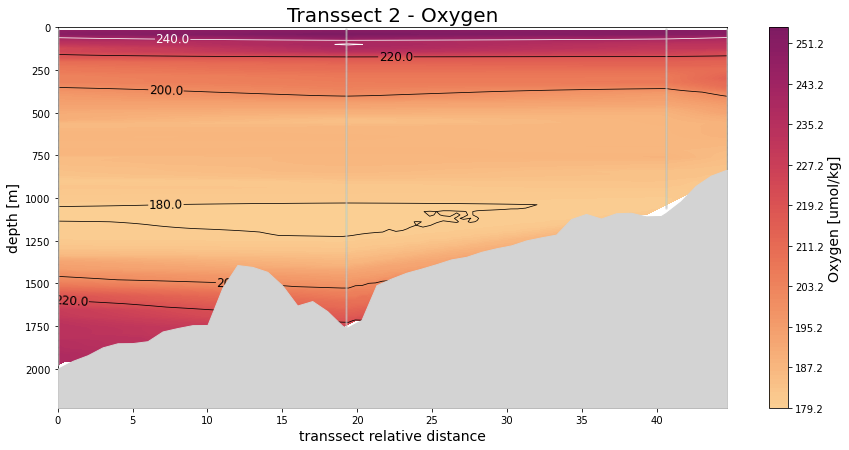

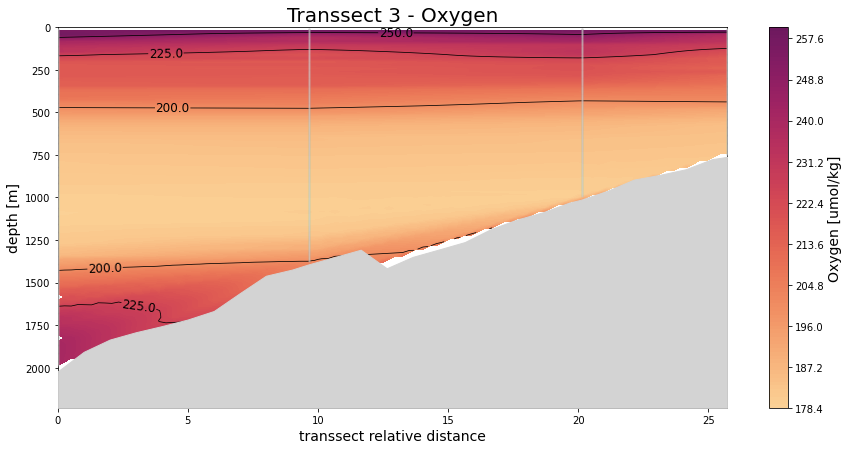

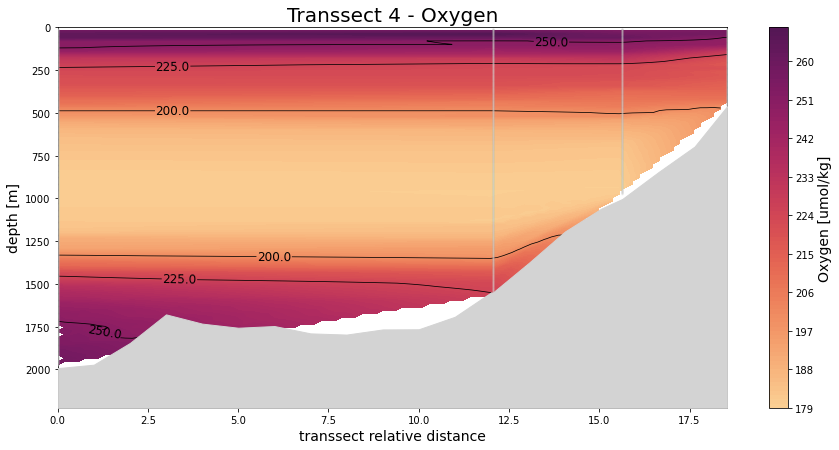

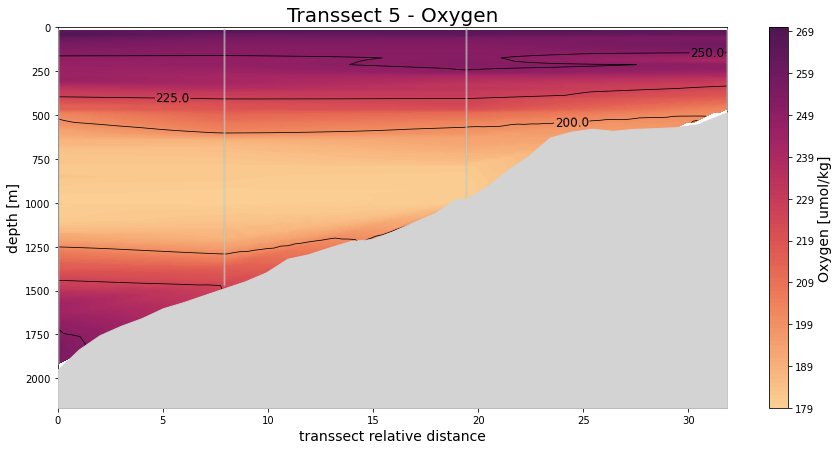

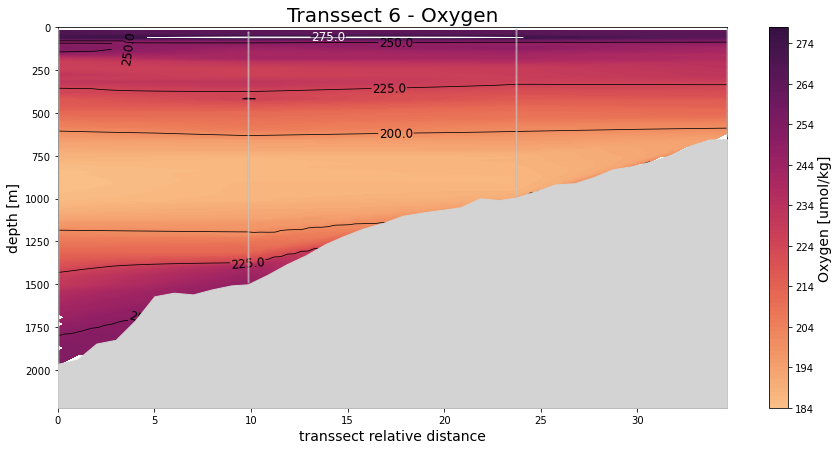

In [34]:
#Select the plotting parameters
#t = 'transsect_3'
variable = 'oxygen'
#cmap = 'viridis'
cmap = cmocean.cm.matter
interpolation = 'linear'    #other options are 'cubic', 'linear', 'nearest'
fontsize_title = 20
fontsize_label = 14

levels = np.linspace(170, 280, 100)
for t in transsects.keys():
    
    #Plotting the vertical section
    fig, ax = plt.subplots(1,1, figsize = (15,7))
    
    n_dep = dataset_transsects[t]['depth'].max()
    maxdist = dataset_transsects[t]['distances'].max()/1000
    
    #Axis limits
    ax.set_xlim(0, maxdist)
    ax.set_ylim(n_dep+250, 0)
    ax.margins(0.05)
    
    #PLot the bathymetry
    ax.fill_between(transsects_bath[t]['distance']/1000, transsects_bath[t]['bathymetry']*-1, n_dep+250, 
                     color='lightgray', zorder=100)
    
    #Creating the grid
    points = list(zip(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth']))
    xi, yi = np.mgrid[0:maxdist:100j, 0:n_dep:100j]
    grid_ztest = griddata(points, dataset_transsects[t][variable], (xi, yi), method=interpolation, rescale=True )
    
    ##Creating the grid - version 2
    ##interp = scipy.interpolate.Rbf(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], ompa_transsect[watermass], function=interpolation)
    ##xi, yi = np.mgrid[0:maxdist:50j, depth_range_upper:n_dep:50j]
    ##zi = interp(xi, yi)
    
    #Colouring the grid
    #levels = []
    
    #handle = ax.contourf(xi, yi, grid_ztest, cmap=cmap, levels=100)
    handle = ax.contourf(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
    #handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
    #handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
    
    #if we use a divergent color map and want the zero to be the white colour
    ##if abs(grid_ztest.max()) > abs(grid_ztest.min()):
    ##    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=grid_ztest.max(), vmin=-grid_ztest.max())
    ##else:
    ##    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=-grid_ztest.min(), vmin=grid_ztest.min())
    
    #contouring 
    clevels = 3   #int or list
    CS = ax.contour(xi, yi, grid_ztest, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)
    ax.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=12, zorder=20)
    
    #Ploting the CTD stations cast
    b = ax.scatter(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)
    
    #colorbar
    #cb = fig.colorbar(handle, ax=ax0, ticks=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
    cb = fig.colorbar(handle, ax=ax)
    cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)
    
    #titles
    plt.ylabel('depth [m]', fontsize=fontsize_label)
    plt.xlabel('transsect relative distance', fontsize=fontsize_label)
    plt.title('Transsect '+t[-1]+' - '+variable[0].upper()+variable[1:], fontsize=fontsize_title)
    
    plt.show()

# Vertical Section of all the stations

In [39]:
new_transsect = []
for ncast in data.keys():
    if data[ncast]['depth'].iloc[-1] < 2000:
        new_transsect.append(ncast)
new_transsect.remove('15')
transsects['all_stations_v2'] = new_transsect

#Select a transsect
t = 'all_stations_v2'
transsect = transsects[t]

#Compute and store bathymetry of the transsect
transsects_sel = {}
transsects_sel[t] = transsect

In [40]:
#path to bathymetry file
gebco = 'C:/Users/pauab/Universidad/Data/TFM/Bathymetry/GEBCO_16_Feb_2022_8d3ca050bc32/gebco_2021_n44.857177734375_s34.991455078125_w-11.97509765625_e-4.37255859375.nc'

#function that computes and stores the bathymetry in a dict
transsects_bath_v2 = bathymetry_transsects(data, transsects=transsects, xoffset=False, gebco=gebco)

In [41]:
#Compute the distances between the stations of a transsect
distances_v2 = transsect_distances(data, transsects=transsects)

In [43]:
#Store the data of the stations of a transsect in a concatenate DF (useful to then plot)
dataset_transsects_v2 = transsects_dataconc(data, transsects = transsects, distances = distances_v2)

In [46]:
lowres_bath = True
if lowres_bath == True:
    bath = []
    for ncast in transsects[t]:
        bath.append(data[ncast].index[-1])

    for i in range(len(bath)):
        if bath[i] == 837:
            bath[i] = 2000
        elif bath[i] == 1059:
            bath[i] = 2000
        elif bath[i] == 1373:
            bath[i] = 2000
        elif bath[i] == 992:
            bath[i] = 2000
        elif bath[i] == 746:
            bath[i] = 2000
        elif bath[i] == 968:
            bath[i] = 2000
        elif bath[i] == 453:
            bath[i] = 2000
        elif bath[i] == 470:
            bath[i] = 2000
        elif bath[i] == 984:
            bath[i] = 2000
        elif bath[i] == 1464:
            bath[i] = 2000

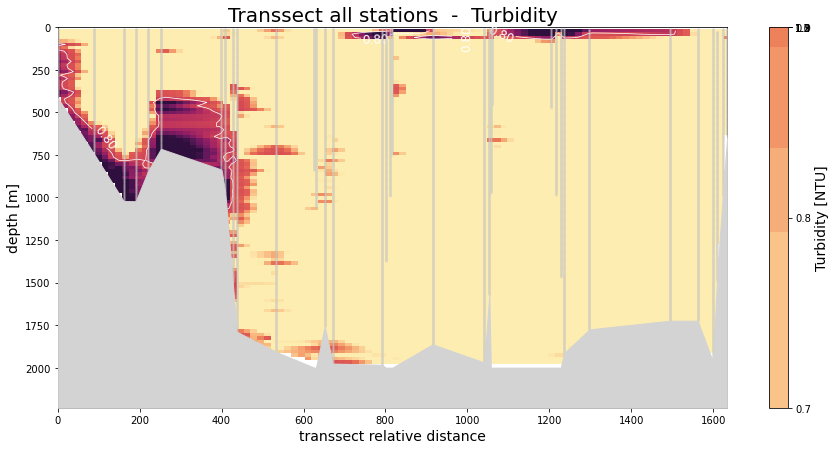

In [110]:
#Select the plotting parameters
lowres_bath = True
t = 'all_stations_v2'
variable = 'turbidity'
#cmap = 'viridis'
cmap = cmocean.cm.matter
interpolation = 'linear'    #other options are 'cubic', 'linear', 'nearest'
fontsize_title = 20
fontsize_label = 14

#Plotting the vertical section
fig, ax = plt.subplots(1,1, figsize = (15,7))

n_dep = dataset_transsects_v2[t]['depth'].max()
maxdist = dataset_transsects_v2[t]['distances'].max()/1000

#Axis limits
ax.set_xlim(0, maxdist)
ax.set_ylim(n_dep+250, 0)
ax.margins(0.05)

#Plot the bathymetry
if lowres_bath == True:
    plt.fill_between(list(dict.fromkeys(dataset_transsects_v2[t]['distances']/1000)), bath, n_dep+250, 
                        color='lightgray', zorder=50)
else:
    plt.fill_between(transsects_bath_v2[t]['distance']/1000, transsects_bath_v2[t]['bathymetry']*-1, n_dep+250, 
                        color='lightgray', zorder=100)

#Creating the grid
points = list(zip(dataset_transsects_v2[t]['distances']/1000, dataset_transsects_v2[t]['depth']))
xi, yi = np.mgrid[0:maxdist:100j, 0:n_dep:100j]
grid_ztest = griddata(points, dataset_transsects_v2[t][variable], (xi, yi), method=interpolation, rescale=True )

##Creating the grid - version 2
##interp = scipy.interpolate.Rbf(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], ompa_transsect[watermass], function=interpolation)
##xi, yi = np.mgrid[0:maxdist:50j, depth_range_upper:n_dep:50j]
##zi = interp(xi, yi)

#Colouring the grid
levels = np.linspace(0.77, 0.92, 100)     #for turbidity
levels = [0.765, 0.7675, 0.77, 0.7725, 0.775, 0.7775, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86]
#handle = ax.contourf(xi, yi, grid_ztest, cmap=cmap, levels=100)
#handle = ax.contourf(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
#handle = ax.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
handle = ax.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto', norm=PiecewiseNorm(levels))

#if we use a divergent color map and want the zero to be the white colour
##if abs(grid_ztest.max()) > abs(grid_ztest.min()):
##    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=grid_ztest.max(), vmin=-grid_ztest.max())
##else:
##    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=-grid_ztest.min(), vmin=grid_ztest.min())

#contouring 
clevels = [0.8]   #int or list
CS = ax.contour(xi, yi, grid_ztest, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)
ax.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=12, zorder=20)

#Ploting the CTD stations cast
b = ax.scatter(dataset_transsects_v2[t]['distances']/1000, dataset_transsects_v2[t]['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)

#colorbar
#cb = fig.colorbar(handle, ax=ax0, ticks=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
cb = fig.colorbar(handle, ax=ax)
cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
plt.title('Transsect all stations'+'  -  '+variable[0].upper()+variable[1:], fontsize=fontsize_title)

plt.show()